In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import json
import random
import statistics
import numpy as np

from rtree import index
from utils import *

In [2]:
G = ox.save_load.load_graphml(filename="Singapore_drive.graphml")
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

# get 100 sources
sources = nodes['osmid'].values[:100]
# get 100 targets
targets = nodes['osmid'].values[-100:]

In [3]:
# Fill in all nodes to find neighbours
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']

for node, x, y in zip(node_id, xx, yy):
    idx.insert(int(node), (x,y,x,y))

In [6]:
def bingo(sources, targets):
    
    h_time = []
    mh_time = []
    h_query = []
    e_query = []
    mh_query = []
    
    count = 0
    for s,t in zip(sources,targets):
        orig_point = nodes[nodes['osmid'] == s].geometry.values[0]
        target_point = nodes[nodes['osmid'] == t].geometry.values[0]
        orig_xy = (orig_point.y, orig_point.x)
        target_xy = (target_point.y, target_point.x)

        # Find all nodes within 500m from candidate sources and destinations
        candidate_dest = find_nearest_nodes(nodes, target_xy, 500, idx)
        candidate_source = find_nearest_nodes(nodes, orig_xy, 500, idx)

        eq = len(candidate_dest) * len(candidate_source)
        e_query.append(eq)

        euclidean = get_length_dict(nodes, candidate_source, candidate_dest)        
        (ht, hq, mht, mhq) = modified_hybrid_search(nodes, euclidean)
        
        h_time.append(ht)
        h_query.append(hq)
        mh_time.append(mht)
        mh_query.append(mhq)
        
        count += 1
        print(count, s, t, hq, mhq, eq)

    return mh_query, mh_time, h_query, h_time, e_query

## Off-peak

In [7]:
mh_query_off, mh_time_off, h_query_off, h_time_off, e_query_off = bingo(sources, targets)

3400
1
1 1820000257 1389166316 1 1 3400
13794


KeyboardInterrupt: 

## Mod-peak

In [6]:
mh_query_mod, mh_time_mod, h_query_mod, h_time_mod, e_query_mod = bingo(sources, targets)

1 1820000257 1369047017
2 3874553858 4604559340
3 1820000259 4594335727
4 3874553857 244908016
5 2083586053 4604559345
6 889323526 4594335729
7 3874553861 1398079475
8 244908034 4594335734
9 237568006 4604559352
10 2083586060 1820000251


## High-peak

In [7]:
mh_query_high, mh_time_high, h_query_high, h_time_high, e_query_high = bingo(sources, targets)

1 1820000257 1369047017
2 3874553858 4604559340
3 1820000259 4594335727
4 3874553857 244908016
5 2083586053 4604559345
6 889323526 4594335729
7 3874553861 1398079475
8 244908034 4594335734
9 237568006 4604559352
10 2083586060 1820000251


## Plot!

In [8]:
import matplotlib.pyplot as plt

# Average of: 
et = [statistics.mean(e_time_off), statistics.mean(e_time_mod), statistics.mean(e_time_high)] 
ht = [statistics.mean(h_time_off), statistics.mean(h_time_mod), statistics.mean(h_time_high)]
eq = [statistics.mean(e_query_off), statistics.mean(e_query_mod), statistics.mean(e_query_high)]
hq = [statistics.mean(h_query_off), statistics.mean(h_query_mod), statistics.mean(h_query_high)]

labels = ["Off-Peak(12:00 A.M.)", "Moderately-Peak(3:00 P.M.)", "High-Peak(6:00 P.M.)"]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

def autolabel(rects, ax, xpos='center'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(math.ceil(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha='center', va='bottom')

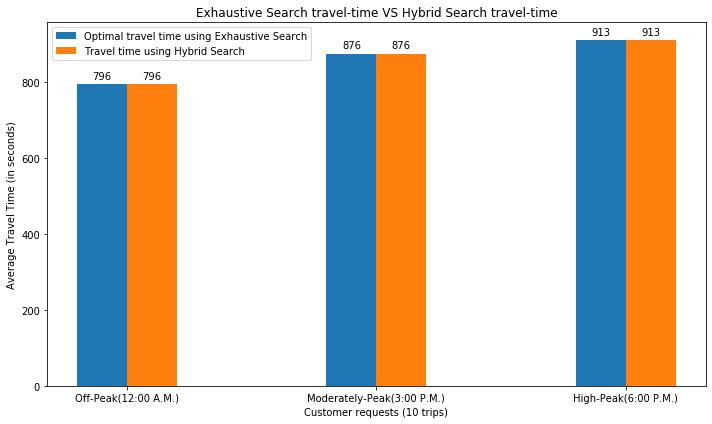

In [15]:
fig1, ax1 = plt.subplots(figsize=(10,6))
rects1 = ax1.bar(x - width/2, et, width, label='Optimal travel time using Exhaustive Search')
rects2 = ax1.bar(x + width/2, ht, width, label='Travel time using Hybrid Search')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Average Travel Time (in seconds)')
ax1.set_xlabel('Customer requests (10 trips)')
ax1.set_title('Exhaustive Search travel-time VS Hybrid Search travel-time')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

autolabel(rects1, ax1)
autolabel(rects2, ax1)
fig1.tight_layout()

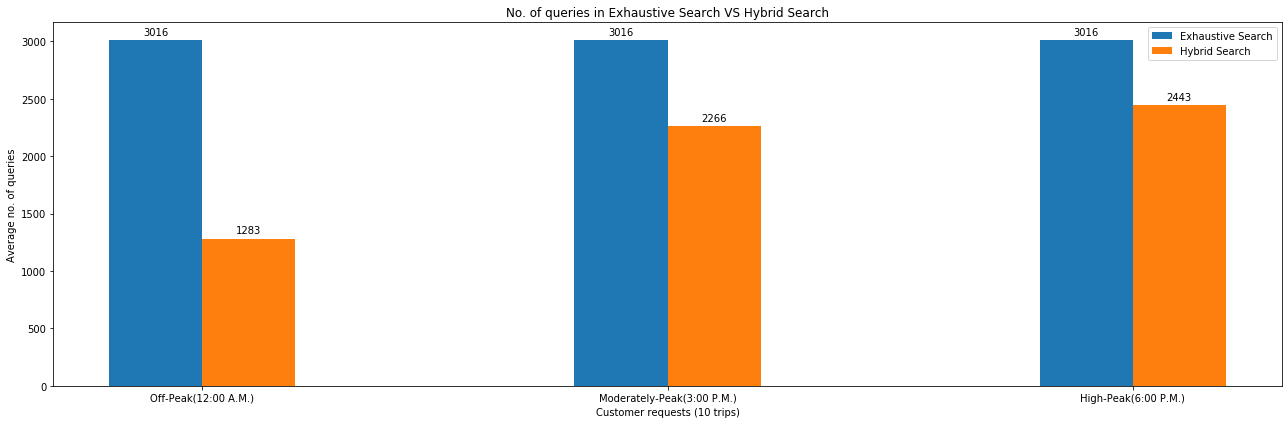

In [24]:
fig2, ax2 = plt.subplots(figsize=(18,6))
rects3 = ax2.bar(x - width/2, eq, width, label='Exhaustive Search')
rects4 = ax2.bar(x + width/2, hq, width, label='Hybrid Search')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Average no. of queries')
ax2.set_xlabel('Customer requests (10 trips)')
ax2.set_title('No. of queries in Exhaustive Search VS Hybrid Search')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

autolabel(rects3, ax2)
autolabel(rects4, ax2)
fig2.tight_layout()